In [1161]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pickle as pkl


In [1162]:
df = pd.read_csv('all_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [1163]:
df

,crude_oil_Price,crude_oil_Open,crude_oil_High,crude_oil_Low,crude_oil_Vol.,crude_oil_Change %,gold_Open,gold_High,gold_Low,gold_Close,...,silver_Change %,dollar_rate_Price,dollar_rate_Open,dollar_rate_High,dollar_rate_Low,dollar_rate_Change %,cpi_CPI,ppi_PPI,m1sl_M1SL,is_holiday
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,98.61,98.76,98.54,NaN,0.28,NaN,NaN,NaN,NaN,...,NaN,80.03,80.21,80.24,80.10,0.00,234.100,201.200,2638.8,1
2014-01-02,95.44,98.50,98.97,95.34,251250.0,-3.30,117.930000,118.730003,117.750000,118.000000,...,3.91,80.63,80.12,80.71,80.08,0.75,234.100,201.200,2638.8,0
2014-01-03,93.96,95.47,95.74,93.86,215520.0,-1.55,118.639999,119.620003,118.589996,119.290001,...,0.41,80.79,80.57,80.89,80.49,0.20,234.100,201.200,2638.8,0
2014-01-06,93.43,94.18,94.59,93.20,189380.0,-0.56,119.760002,120.389999,117.110001,119.500000,...,-0.53,80.65,80.86,80.91,80.54,-0.17,234.100,201.200,2638.8,0
2014-01-07,93.67,93.60,94.22,93.35,177180.0,0.26,118.459999,118.919998,118.129997,118.820000,...,-1.57,80.83,80.69,80.95,80.60,0.22,234.100,201.200,2638.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,75.56,77.28,77.69,75.52,365120.0,-2.21,233.449997,233.500000,232.059998,232.759995,...,-1.93,104.66,104.37,104.67,104.14,0.27,313.207,256.772,17978.9,0
2024-08-27,75.56,77.28,77.69,75.52,365120.0,-2.21,231.690002,233.470001,231.570007,233.389999,...,-1.93,104.66,104.37,104.67,104.14,0.27,313.207,256.772,17978.9,0
2024-08-28,75.56,77.28,77.69,75.52,365120.0,-2.21,232.000000,232.020004,230.729996,231.750000,...,-1.93,104.66,104.37,104.67,104.14,0.27,313.207,256.772,17978.9,0


Data Preprocessing - checking correlation and cointegration

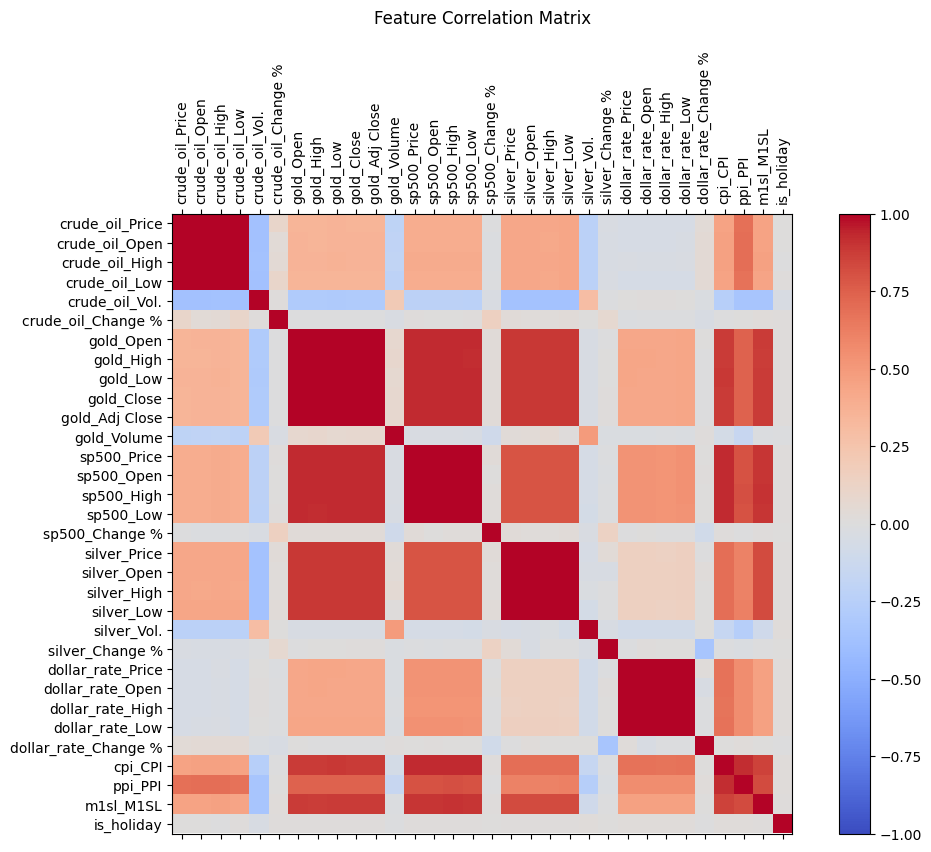

In [1164]:
import matplotlib.pyplot as plt

def plot_corr_matrix(df):
    correlation_matrix = df.corr()
    
    # Plotting the correlation matrix with Matplotlib
    plt.figure(figsize=(12, 8))
    plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, fignum=1)
    plt.colorbar()
    
    # Set tick labels for the correlation matrix
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
    
    # Annotate each cell with the numeric value of the correlation
    """for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')
    """
    plt.title("Feature Correlation Matrix", pad=20)
    plt.show()

plot_corr_matrix(df)

In [1165]:
df['gold_price_yesterday'] = df['gold_Close'].shift(1)
df['gold_price_2days'] = df['gold_Close'].shift(2)
df['gold_price_3days'] = df['gold_Close'].shift(3)

In [1166]:
# adding columns to predict - dependent on number of days
df = df[['gold_Close', 'silver_Price', 'sp500_Price','gold_price_yesterday', 'gold_price_2days', 'gold_price_3days','cpi_CPI', 'ppi_PPI', 'm1sl_M1SL', 'dollar_rate_Price','is_holiday']]

num_days = 30 # Number of days to predict
# Prepare target columns for x-day predictions
for i in range(1, num_days + 1):
    df[f'target_day_{i}'] = df['gold_Close'].shift(-i)

# Drop rows with NaN values from shifting
#df = df.dropna()
# Separate features and targets
# filter df to leave only 1 column of each type
#X = df.drop(columns=[f'target_day_{i}' for i in range(1, num_days + 1)])
#y = df[[f'target_day_{i}' for i in range(1, num_days + 1)]]
"""# scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_dropped = X_train.dropna()
#print(len(X_train_dropped))
y_train_dropped = y_train.loc[X_train_dropped.index]

# Drop rows with NaN in X_test and y_test
X_test_dropped = X_test.dropna()
y_test_dropped = y_test.loc[X_test_dropped.index]

# Ensure that y_test_dropped does not contain NaN values
X_test_dropped = X_test_dropped.dropna()
y_test_dropped = y_test_dropped.dropna()

# Check if indices still match after dropping NaNs
common_index = X_test_dropped.index.intersection(y_test_dropped.index)
X_test_dropped = X_test_dropped.loc[common_index]
y_test_dropped = y_test_dropped.loc[common_index]

X"""

/var/folders/zp/tjm6hdl95rjgm9v39jqzvwb00000gq/T/ipykernel_41408/851247892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'target_day_{i}'] = df['gold_Close'].shift(-i)
/var/folders/zp/tjm6hdl95rjgm9v39jqzvwb00000gq/T/ipykernel_41408/851247892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'target_day_{i}'] = df['gold_Close'].shift(-i)
/var/folders/zp/tjm6hdl95rjgm9v39jqzvwb00000gq/T/ipykernel_41408/851247892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

'# scale data\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)\n\nX_train_dropped = X_train.dropna()\n#print(len(X_train_dropped))\ny_train_dropped = y_train.loc[X_train_dropped.index]\n\n# Drop rows with NaN in X_test and y_test\nX_test_dropped = X_test.dropna()\ny_test_dropped = y_test.loc[X_test_dropped.index]\n\n# Ensure that y_test_dropped does not contain NaN values\nX_test_dropped = X_test_dropped.dropna()\ny_test_dropped = y_test_dropped.dropna()\n\n# Check if indices still match after dropping NaNs\ncommon_index = X_test_dropped.index.intersection(y_test_dropped.index)\nX_test_dropped = X_test_dropped.loc[common_index]\ny_test_dropped = y_test_dropped.loc[common_index]\n\nX'

In [1167]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Number of days to predict
num_days = 30  

# Prepare target columns for x-day predictions
for i in range(1, num_days + 1):
    df[f'target_day_{i}'] = df['gold_Close'].shift(-i)

# Drop rows with NaN values from shifting
df = df.dropna()

# Separate features and targets
X = df.drop(columns=[f'target_day_{i}' for i in range(1, num_days + 1)])
y = df[[f'target_day_{i}' for i in range(1, num_days + 1)]]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler on X_train and transform X_train and X_test
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=X.columns, index=X_test.index)

# Fit the scaler on y_train and transform y_train and y_test
y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train), columns=y.columns, index=y_train.index)
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test), columns=y.columns, index=y_test.index)

# Drop NaNs from scaled train sets (ensures rows align with shifted target data)
X_train_dropped = X_train_scaled.dropna()
y_train_dropped = y_train_scaled.loc[X_train_dropped.index]

# Drop NaNs from scaled test sets and ensure alignment
X_test_scaled_dropped = X_test_scaled.dropna()
y_test_scaled_dropped = y_test_scaled.loc[X_test_scaled_dropped.index]

# Ensure indices match for test data after NaN drops
common_index = X_test_scaled_dropped.index.intersection(y_test_scaled_dropped.index)
X_test_dropped = X_test_scaled_dropped.loc[common_index]
y_test_dropped = y_test_scaled_dropped.loc[common_index]

In [1168]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

# Apply RFE
selector = RFE(model, n_features_to_select=10)  # Choose how many features to select
selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[selector.support_]
print(f"Selected features: {selected_features}")

# Train model with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
model.fit(X_train_selected, y_train)
y_pred_selected = model.predict(X_test_selected)

# Evaluate the model
rmse_selected = mean_squared_error(y_test, y_pred_selected, squared=False)

Selected features: Index(['gold_Close', 'silver_Price', 'sp500_Price', 'gold_price_yesterday',
       'gold_price_2days', 'gold_price_3days', 'cpi_CPI', 'ppi_PPI',
       'dollar_rate_Price', 'is_holiday'],
      dtype='object')


/Library/Python/3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [1169]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# Fit the MultiOutputRegressor
model = MultiOutputRegressor(LinearRegression())
#model = LinearRegression()
model.fit(X_train_dropped, y_train_dropped)

# Initialize list to hold summary data for each target day
summary_data = []

# Extract feature names from X_train_dropped
feature_names = X_train_dropped.columns

# For each target day, get the model's coefficients, intercept, and performance metrics
for day_index, estimator in enumerate(model.estimators_):
    # Get coefficients as a Series with feature names
    coefficients = pd.Series(estimator.coef_, index=feature_names)
    intercept = estimator.intercept_
    
    # Calculate predictions and performance metrics
    y_pred = estimator.predict(X_train_dropped)
    mse = mean_squared_error(y_train_dropped.iloc[:, day_index], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train_dropped.iloc[:, day_index], y_pred)

    # Create a DataFrame for the day's coefficients with metrics included
    day_summary = pd.DataFrame({
        'Coefficient': coefficients,
        'Intercept': intercept,
        'MSE': mse,
        'RMSE': rmse,
        'R^2': r2,
    })
    summary_data.append(day_summary)

# Concatenate all day summaries into a single DataFrame for display
summary_df = pd.concat(summary_data, keys=[f'Target Day {i+1}' for i in range(len(summary_data))])

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Show the full summary with feature names and coefficients
print("Detailed Coefficients Summary for Each Target Day:")
#print(summary_df)

# Reset display options to default after viewing if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
summary_df

Detailed Coefficients Summary for Each Target Day:


Coefficient     Intercept       MSE  \
Target Day 1  gold_Close               1.014358  7.269403e-17  0.002617   
              silver_Price            -0.014561  7.269403e-17  0.002617   
              sp500_Price             -0.000245  7.269403e-17  0.002617   
              gold_price_yesterday    -0.032426  7.269403e-17  0.002617   
              gold_price_2days         0.024494  7.269403e-17  0.002617   
...                                         ...           ...       ...   
Target Day 30 cpi_CPI                  0.019462 -1.726869e-15  0.050371   
              ppi_PPI                 -0.096973 -1.726869e-15  0.050371   
              m1sl_M1SL                0.153602 -1.726869e-15  0.050371   
              dollar_rate_Price       -0.072830 -1.726869e-15  0.050371   
              is_holiday               0.005004 -1.726869e-15  0.050371   

                                        RMSE       R^2  
Target Day 1  gold_Close            0.051161  0.997383  
              silver_Price          0.051161  0.997383  
              sp500_Price           0.051161  0.997383  
              gold_price_yesterday  0.051161  0.997383  
              gold_price_2days      0.051161  0.997383  
...                                      ...       ...  
Target Day 30 cpi_CPI               0.224434  0.949629  
              ppi_PPI               0.224434  0.949629  
              m1sl_M1SL             0.224434  0.949629  
              dollar_rate_Price     0.224434  0.949629  
              is_holiday            0.224434  0.949629  

[330 rows x 5 columns]

11


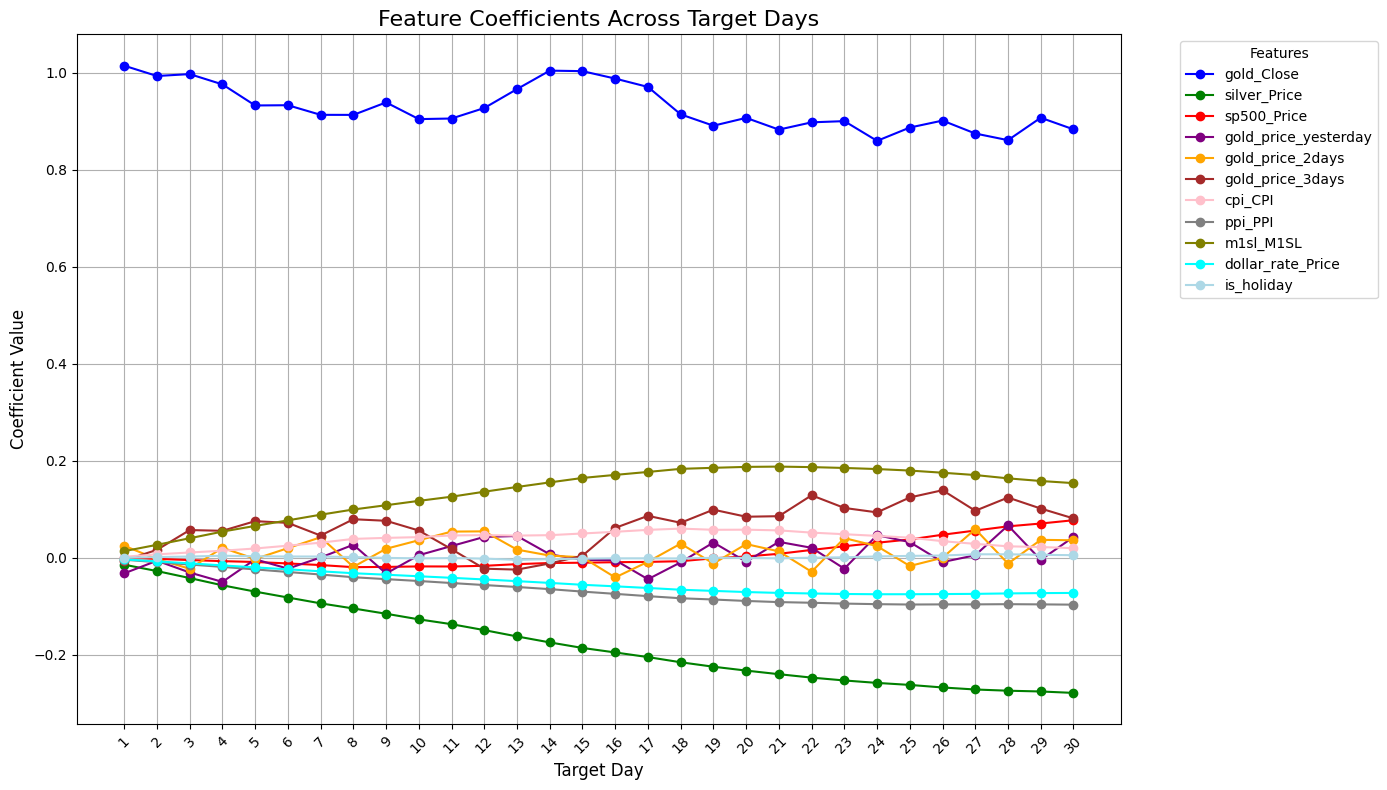

In [1170]:
import matplotlib.pyplot as plt

# Create a DataFrame to store the coefficients for each target day
coefficients_df = pd.DataFrame()

# Loop through each day's model and extract the coefficients for the relevant features
for day_index, estimator in enumerate(model.estimators_):
    # Get coefficients as a Series with feature names
    coefficients = pd.Series(estimator.coef_, index=feature_names)
    
    # Add the coefficients for the target day to the DataFrame
    coefficients_df[f'{day_index + 1}'] = coefficients

# Plot the coefficients for each feature across target days
plt.figure(figsize=(14, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'lightblue', 'mediumblue', 'teal', 'dodgerblue', 'lightgreen']  # Add more colors if needed
# Loop over the rows (features) and plot them
i=0
print(len(coefficients_df.index))
for feature in coefficients_df.index:
    plt.plot(coefficients_df.columns, coefficients_df.loc[feature, :], label=feature, color = colors[i], marker='o')
    i+=1

# Add labels and title
plt.title('Feature Coefficients Across Target Days', fontsize=16)
plt.xlabel('Target Day', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

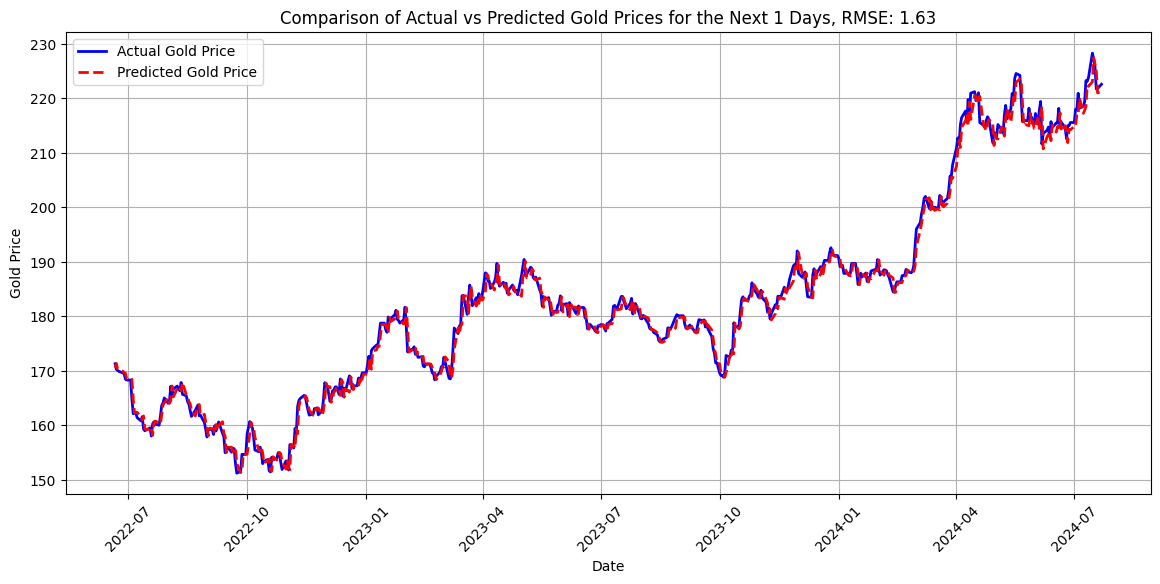

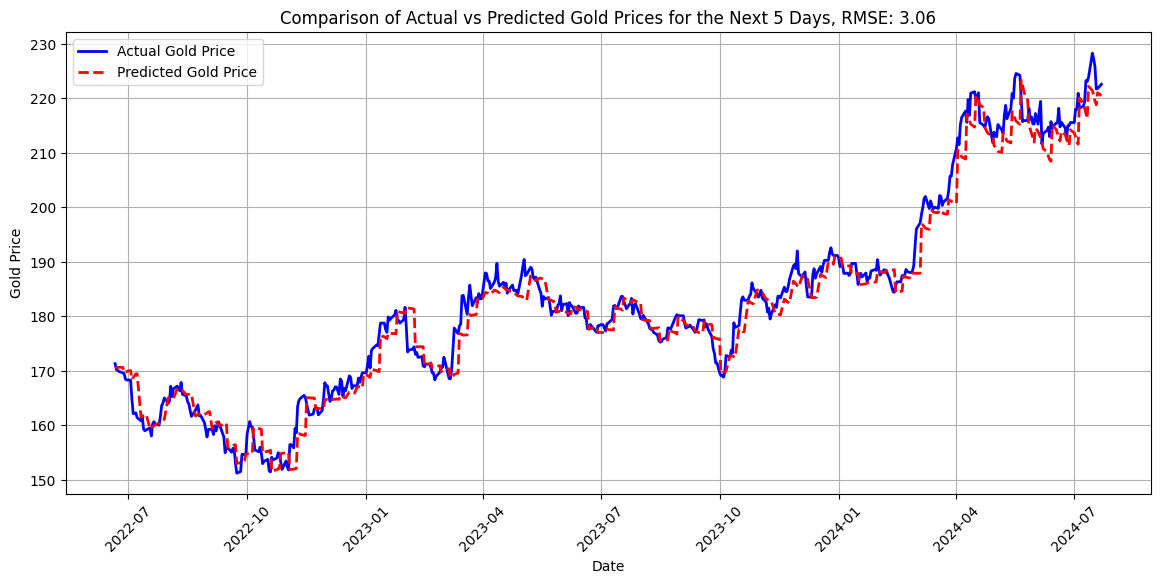

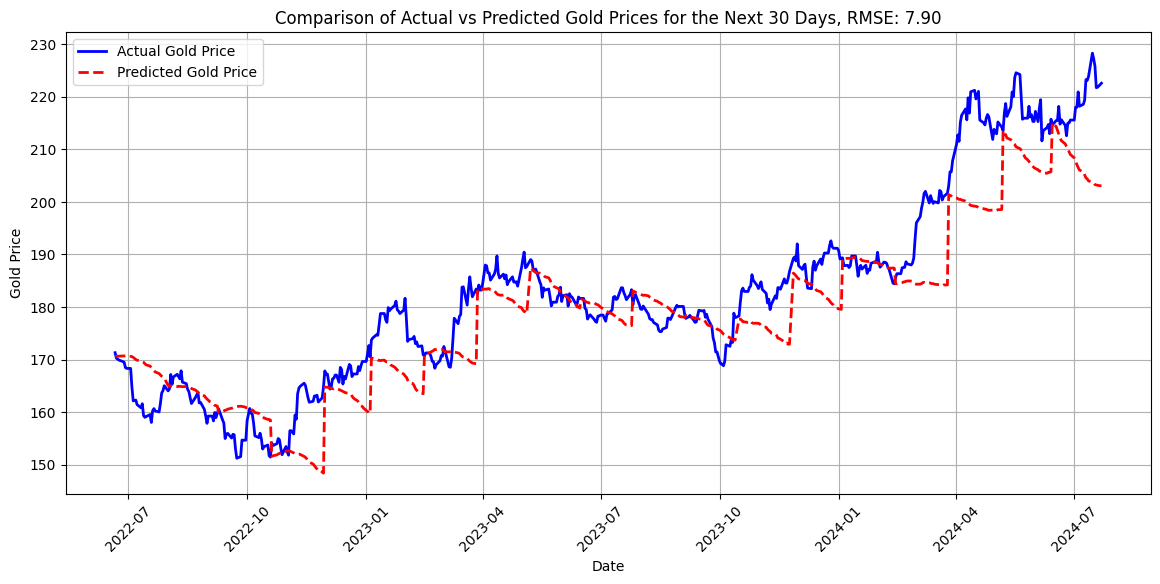

{1:                     LR        True
 2022-06-21  170.601559  171.309998
 2022-06-22  171.348035  170.259995
 2022-06-23  170.275329  170.089996
 2022-06-24  170.153199  169.899994
 2022-06-27  169.936254  169.619995
 ...                ...         ...
 2024-07-16  227.465662  227.229996
 2024-07-17  226.372035  225.779999
 2024-07-18  225.047333  221.729996
 2024-07-19  221.012869  221.800003
 2024-07-22  221.185230  222.580002
 
 [567 rows x 2 columns],
 5:                     LR        True
 2022-06-21  170.601559  171.309998
 2022-06-22  170.628509  170.259995
 2022-06-23  170.639221  170.089996
 2022-06-24  170.647270  169.899994
 2022-06-27  170.659356  169.619995
 ...                ...         ...
 2024-07-16  220.515266  227.229996
 2024-07-17  219.516363  225.779999
 2024-07-18  218.820475  221.729996
 2024-07-19  221.012869  221.800003
 2024-07-22  220.510084  222.580002
 
 [567 rows x 2 columns],
 30:                     LR        True
 2022-06-21  170.601559  171.309998


In [1183]:
import matplotlib.pyplot as plt
import pandas as pd
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_dropped, y_train_dropped)
predictions_scaled = model.predict(X_test_dropped)  # Replace with your model's predictions
predictions = scaler_y.inverse_transform(predictions_scaled)  # Convert back to original scale

def plot_results(predictions, num_of_days=6):
    # Extract the actual values for the test period (y_test_dropped)
    actual_values = scaler_y.inverse_transform(y_test_dropped)[:, 0]  # Only target_day_1 as example
    actual_dates = y_test_dropped.index
    # Prepare lists for concatenating predicted values and corresponding dates
    predicted_values = []
    predicted_dates = []
    predictions_df = pd.DataFrame(predictions, index=y_test_dropped.index, 
                                  columns=[f'predicted_day_{i+1}' for i in range(predictions.shape[1])])

    # Create the plot for actual values
    plt.figure(figsize=(14, 6))
    plt.plot(actual_dates, actual_values, label='Actual Gold Price', color='blue', linewidth=2)
    true_values_length = len(y_test_dropped)
    # Loop through the predictions and plot them in chunks of `num_of_days`
    for i in range(0, len(predictions_df), num_of_days):
        # Check if this chunk is smaller than num_of_days
        end_index = min(i + num_of_days, len(predictions_df))
        #print(end_index)
        # Take the current chunk, ensuring we don't go out of bounds
        predicted_chunk = predictions_df.iloc[i, :num_of_days]  # Grab the chunk (first row if it's the first row)
        #print(predicted_chunk)
        # Add to the list of predicted values
        predicted_values.extend(predicted_chunk.values.flatten())  # Flatten to avoid nested lists
        predicted_dates.extend(y_test_dropped.index[i:end_index])
    predicted_values = predicted_values[:true_values_length]
    predicted_dates = predicted_dates[:true_values_length]
    # create a df with dates as indexes and values
    predictions_df = pd.DataFrame({
    'LR': predicted_values,  # Replace this with your actual predicted values
    'True': actual_values     # Replace this with the actual values
}, index=predicted_dates) 

        # Plot the predicted values as a single line
    plt.plot(predicted_dates, predicted_values, label='Predicted Gold Price', color='red', linestyle='--', linewidth=2)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    plt.title(f'Comparison of Actual vs Predicted Gold Prices for the Next {num_of_days} Days, RMSE: {rmse:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend(loc='upper left')
    
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.grid()
    plt.show()
    return predictions_df

pred_dict = {}
for i in [1, 5, 30]:
    pred_dict[i] = plot_results(predictions, num_of_days=i)

pred_dict


In [1184]:
# Save to a .pkl file
with open('lr_results_dict.pkl', 'wb') as f:
     pkl.dump(pred_dict, f)

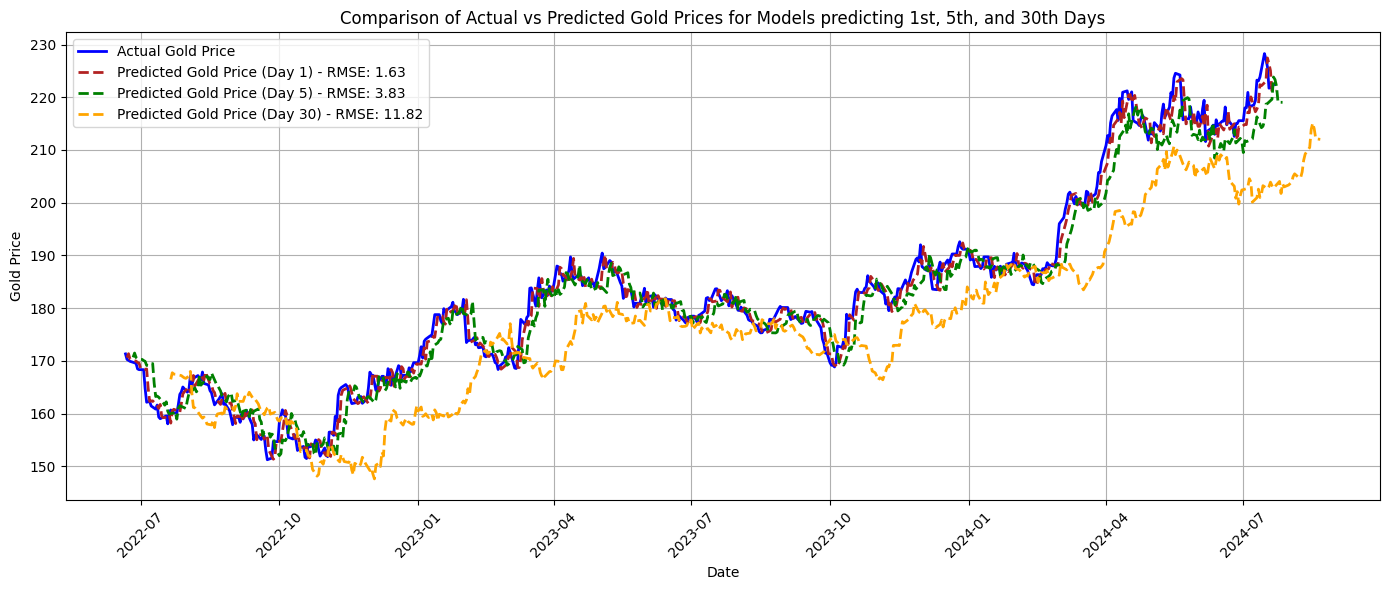

In [1173]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to compute RMSE
def calculate_rmse(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return rmse

# Train the model and make predictions
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_dropped, y_train_dropped)
predictions_scaled = model.predict(X_test_dropped)
predictions = scaler_y.inverse_transform(predictions_scaled)

def plot_results_per_model(predictions, y_test_dropped, model_numbers=[1, 5, 30]):
    plt.figure(figsize=(14, 6))

    # Actual values (using inverse-transformed y_test_dropped)
    actual_values = scaler_y.inverse_transform(y_test_dropped)[:, 0]  # Target day 1 example
    actual_dates = y_test_dropped.index
    plt.plot(actual_dates, actual_values, label='Actual Gold Price', color='blue', linewidth=2)

    # Color choices for different target days
    colors = ['#B22222', 'green', 'orange']
    i = 0

    # Plot the predicted values for each target day (e.g., Day 1, Day 5, Day 30)
    for model_number in model_numbers:
        # Get the predicted values for this target day
        predicted_values = predictions[:, model_number - 1]

        # Inverse-transform the actual values for the specific target day
        actual_values_for_day = scaler_y.inverse_transform(y_test_dropped)[:, model_number - 1]

        # Calculate RMSE for the current model's predictions
        rmse = calculate_rmse(actual_values_for_day, predicted_values)

        # Shift the predicted dates by the number of days in model_number
        shifted_dates = y_test_dropped.index + pd.Timedelta(days=model_number)  # Shift dates forward by model_number days

        # Plot the predicted values for this model_number
        plt.plot(shifted_dates, predicted_values, linestyle='--', color=colors[i], 
                 label=f'Predicted Gold Price (Day {model_number}) - RMSE: {rmse:.2f}', linewidth=2)
        i += 1

    # Title and labels for the plot
    plt.title('Comparison of Actual vs Predicted Gold Prices for Models predicting 1st, 5th, and 30th Days')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Call the function for the target days you want to plot (e.g., Day 1, Day 5, Day 30)
plot_results_per_model(predictions, y_test_dropped, model_numbers=[1, 5, 30])


In [1174]:
import pandas as pd

def create_predictions_df(predictions, num_of_days=30):
    # Initialize an empty list to store concatenated predictions
    predictions_list = []
    
    # Loop over each target day (i.e., column in predictions)
    for i in range(predictions.shape[1]):
        # For each target day, collect predictions by jumping `num_of_days`
        day_predictions = []
        for j in range(0, len(predictions), num_of_days):
            end_index = min(j + num_of_days, len(predictions))
            day_predictions.extend(predictions[j:end_index, i])  # Concatenate predictions
            
        predictions_list.append(day_predictions)
    
    # Convert the concatenated predictions list to a DataFrame
    predictions_df = pd.DataFrame(predictions_list).transpose()
    
    # Set column names for target days (target_day_1, target_day_2, ...)
    predictions_df.columns = [f'target_day_{i+1}' for i in range(predictions.shape[1])]
    
    return predictions_df

# Now, we can create the predictions DataFrame
predictions_df = create_predictions_df(predictions, num_of_days=30)

# Display the predictions DataFrame
print(predictions_df)

# Display the predictions DataFrame
predictions_df


     target_day_1  target_day_2  target_day_3  target_day_4  target_day_5  \
0      170.601559    170.628509    170.639221    170.647270    170.659356   
1      171.348035    171.377382    171.442642    171.486323    171.472161   
2      170.275329    170.386817    170.471241    170.524930    170.627614   
3      170.153199    170.197542    170.256048    170.353481    170.377881   
4      169.936254    170.025864    170.137515    170.197096    170.260953   
..            ...           ...           ...           ...           ...   
562    227.465662    226.590599    225.753731    224.755869    223.840838   
563    226.372035    225.716648    224.859645    223.945659    223.367703   
564    225.047333    224.294790    223.408163    222.745743    222.099885   
565    221.012869    220.510084    219.927182    219.409881    219.058438   
566    221.185230    220.588003    220.084828    219.579307    219.044648   

     target_day_6  target_day_7  target_day_8  target_day_9  target_day_10 

,target_day_1,target_day_2,target_day_3,target_day_4,target_day_5,target_day_6,target_day_7,target_day_8,target_day_9,target_day_10,...,target_day_21,target_day_22,target_day_23,target_day_24,target_day_25,target_day_26,target_day_27,target_day_28,target_day_29,target_day_30
0,170.601559,170.628509,170.639221,170.647270,170.659356,170.666977,170.703416,170.747032,170.671140,170.619854,...,168.773501,168.455264,168.149520,167.908842,167.651693,167.339141,167.071174,166.831609,166.645603,166.476379
1,171.348035,171.377382,171.442642,171.486323,171.472161,171.523946,171.563488,171.618258,171.625239,171.554997,...,169.958315,169.673966,169.410736,169.108433,168.887621,168.621494,168.333965,168.048932,167.942693,167.732184
2,170.275329,170.386817,170.471241,170.524930,170.627614,170.672802,170.755302,170.883550,170.822123,170.827698,...,169.548431,169.290974,168.971748,168.789591,168.573386,168.276006,168.007717,167.841128,167.616254,167.478441
3,170.153199,170.197542,170.256048,170.353481,170.377881,170.448684,170.529368,170.550890,170.574385,170.571928,...,169.299680,169.020842,168.834823,168.603620,168.370897,168.146356,167.962283,167.693731,167.602547,167.452649
4,169.936254,170.025864,170.137515,170.197096,170.260953,170.311114,170.352324,170.459574,170.446944,170.412260,...,169.181319,168.972307,168.698807,168.471557,168.296944,168.063826,167.786425,167.599287,167.440737,167.270759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,227.465662,226.590599,225.753731,224.755869,223.840838,223.153870,222.382785,221.828963,221.322971,220.533601,...,214.336561,214.148373,213.929904,213.626347,213.696476,213.654714,213.482483,213.591088,213.948026,213.927060
563,226.372035,225.716648,224.859645,223.945659,223.367703,222.709279,222.181419,221.787390,221.096427,220.611978,...,215.334345,215.071218,214.736129,214.794648,214.749980,214.531115,214.507148,214.846075,214.869934,215.092533
564,225.047333,224.294790,223.408163,222.745743,222.099885,221.565624,221.131528,220.468611,219.971423,219.564572,...,214.216126,213.780648,213.774895,213.732104,213.496340,213.380712,213.608727,213.595011,213.826052,214.009257
565,221.012869,220.510084,219.927182,219.409881,219.058438,218.579483,218.120285,217.696666,217.185792,216.817066,...,212.263645,212.053736,211.933708,211.952673,211.824157,211.778525,211.855859,212.012142,212.006163,212.137003


Root Mean Square Error: 7.99
Mean Absolute Error: 5.85
R² Score: 0.83


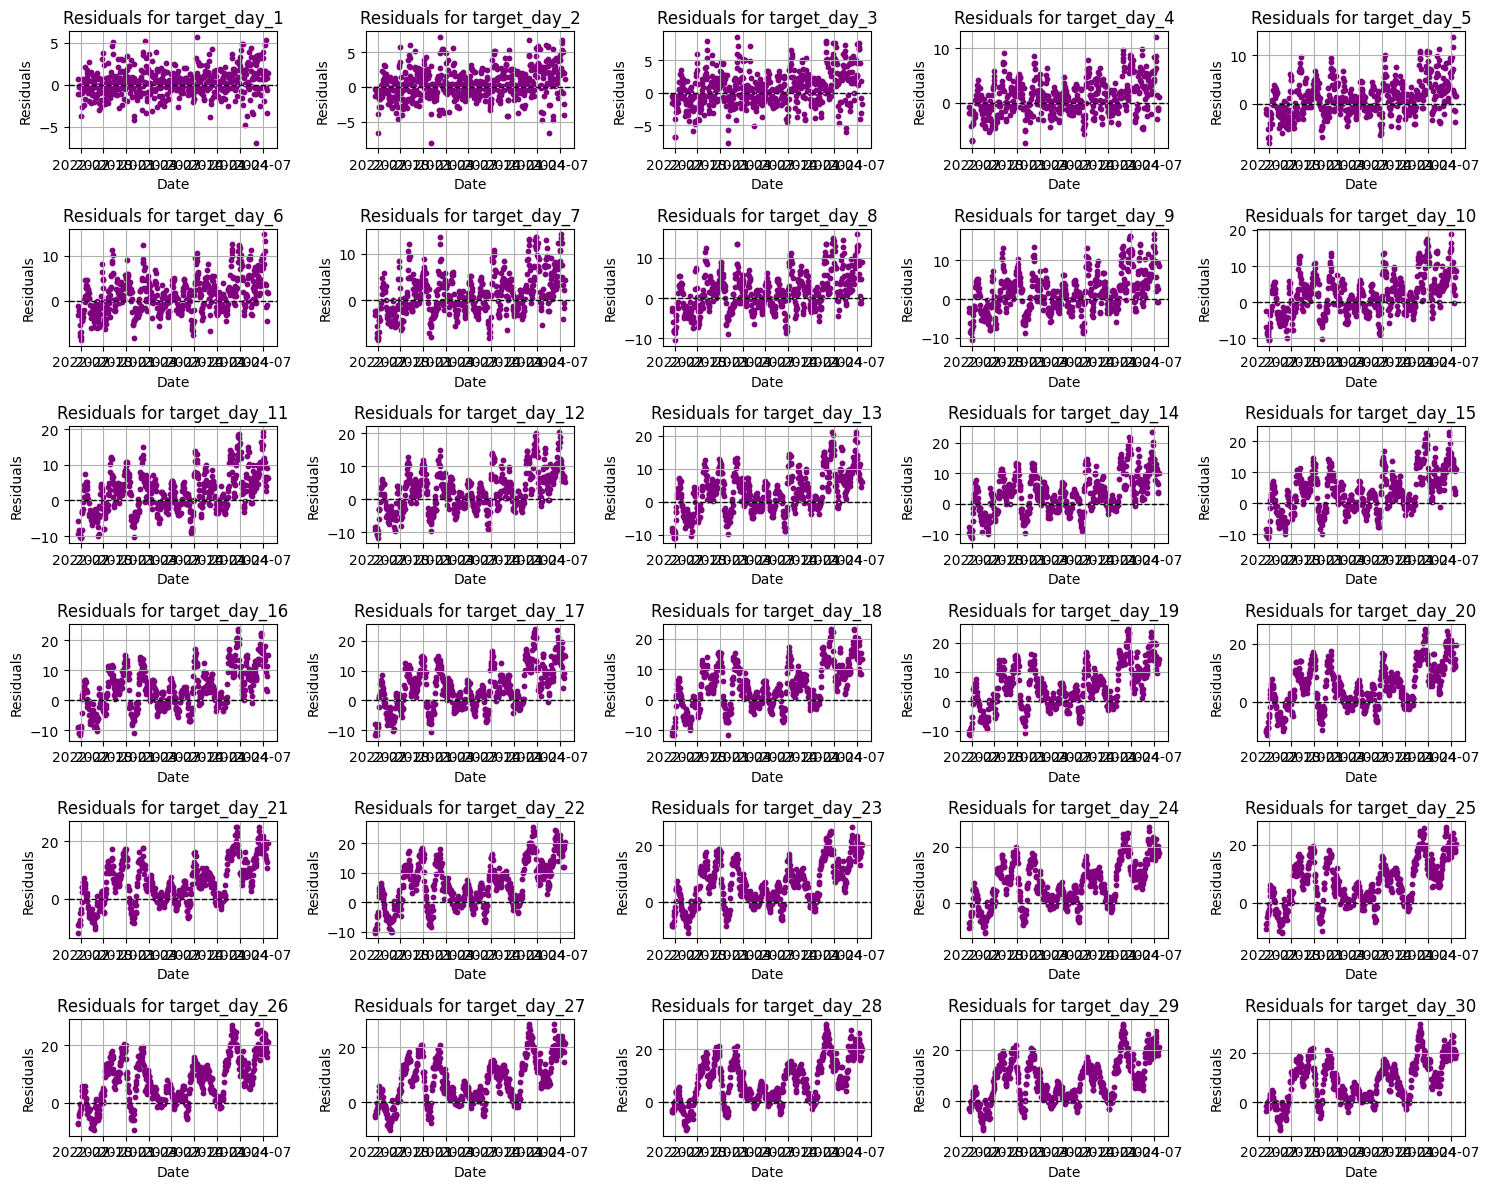

In [1175]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Convert y_test_dropped back to original scale
y_test_dropped_original = scaler_y.inverse_transform(y_test_dropped)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_dropped_original, predictions))
mae = mean_absolute_error(y_test_dropped_original, predictions)
r2 = r2_score(y_test_dropped_original, predictions)

print(f"Root Mean Square Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Calculate residuals
residuals = y_test_dropped_original - predictions

# Prepare target day labels
target_days = [f'target_day_{i}' for i in range(1, 31)]

# Convert residuals to DataFrame for easy access by target days
residuals_df = pd.DataFrame(residuals, index=y_test_dropped.index, columns=target_days)

# Set up the figure and axes for subplots
fig, axes = plt.subplots(6, 5, figsize=(15, 12))
axes = axes.flatten()

# Loop over each target day and plot residuals for that day
for i, target_day in enumerate(target_days):
    residuals_day = residuals_df[target_day]
    
    axes[i].scatter(residuals_df.index, residuals_day, color='purple', s=10)
    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[i].set_title(f'Residuals for {target_day}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Residuals')
    axes[i].grid()

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [1176]:
# Calculate R^2 for each target day (each column in the DataFrame)
r2_scores_per_day = {f'target_day_{i+1}': r2_score(y_test_dropped_original[:, i], predictions[:, i])
                     for i in range(predictions.shape[1])}

# Display individual R^2 scores for each target day
for day, score in r2_scores_per_day.items():
    print(f"{day} R² Score: {score:.2f}")

target_day_1 R² Score: 0.99
target_day_2 R² Score: 0.98
target_day_3 R² Score: 0.98
target_day_4 R² Score: 0.97
target_day_5 R² Score: 0.96
target_day_6 R² Score: 0.95
target_day_7 R² Score: 0.94
target_day_8 R² Score: 0.93
target_day_9 R² Score: 0.91
target_day_10 R² Score: 0.90
target_day_11 R² Score: 0.89
target_day_12 R² Score: 0.88
target_day_13 R² Score: 0.87
target_day_14 R² Score: 0.85
target_day_15 R² Score: 0.84
target_day_16 R² Score: 0.83
target_day_17 R² Score: 0.82
target_day_18 R² Score: 0.81
target_day_19 R² Score: 0.79
target_day_20 R² Score: 0.78
target_day_21 R² Score: 0.77
target_day_22 R² Score: 0.76
target_day_23 R² Score: 0.74
target_day_24 R² Score: 0.73
target_day_25 R² Score: 0.72
target_day_26 R² Score: 0.70
target_day_27 R² Score: 0.68
target_day_28 R² Score: 0.67
target_day_29 R² Score: 0.67
target_day_30 R² Score: 0.65


In [1177]:
# Calculate R^2 for each target day (each column in the DataFrame)
r2_scores_per_day = {f'target_day_{i+1}': r2_score(y_test_dropped_original[:, i], predictions[:, i])
                     for i in range(predictions.shape[1])}


# Calculate MSE and RMSE for each target day (each column in the DataFrame)
mse_scores_per_day = {f'target_day_{i+1}': mean_squared_error(y_test_dropped_original[:, i], predictions[:, i])
                      for i in range(predictions.shape[1])}

print(mse_scores_per_day)
rmse_scores_per_day = {day: np.sqrt(mse) for day, mse in mse_scores_per_day.items()}


# Display individual MSE, RMSE, and R² scores for each target day
for i in range(predictions.shape[1]):
    target_day = f'target_day_{i+1}'
    r2 = r2_scores_per_day[target_day]
    mse = mse_scores_per_day[target_day]
    rmse = rmse_scores_per_day[target_day]
    print(f"{target_day} R² Score: {r2:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")



{'target_day_1': 2.6602499110861855, 'target_day_2': 5.25447697649441, 'target_day_3': 7.920340057154602, 'target_day_4': 11.10462850544245, 'target_day_5': 14.63953960715407, 'target_day_6': 18.276940687252726, 'target_day_7': 22.129571433513984, 'target_day_8': 25.765914068747648, 'target_day_9': 29.99336756667458, 'target_day_10': 34.17718354769424, 'target_day_11': 38.03473033176713, 'target_day_12': 42.40211313312265, 'target_day_13': 47.38543681689164, 'target_day_14': 52.6375305022096, 'target_day_15': 57.66432439548057, 'target_day_16': 62.47065535972598, 'target_day_17': 66.92120748519935, 'target_day_18': 71.48582412864214, 'target_day_19': 76.97617641827324, 'target_day_20': 81.87931647724302, 'target_day_21': 87.06763644357702, 'target_day_22': 93.55297581169309, 'target_day_23': 99.6966613933895, 'target_day_24': 105.26282140554672, 'target_day_25': 110.92089587298568, 'target_day_26': 118.36784949452836, 'target_day_27': 125.02807242635846, 'target_day_28': 130.5956053275

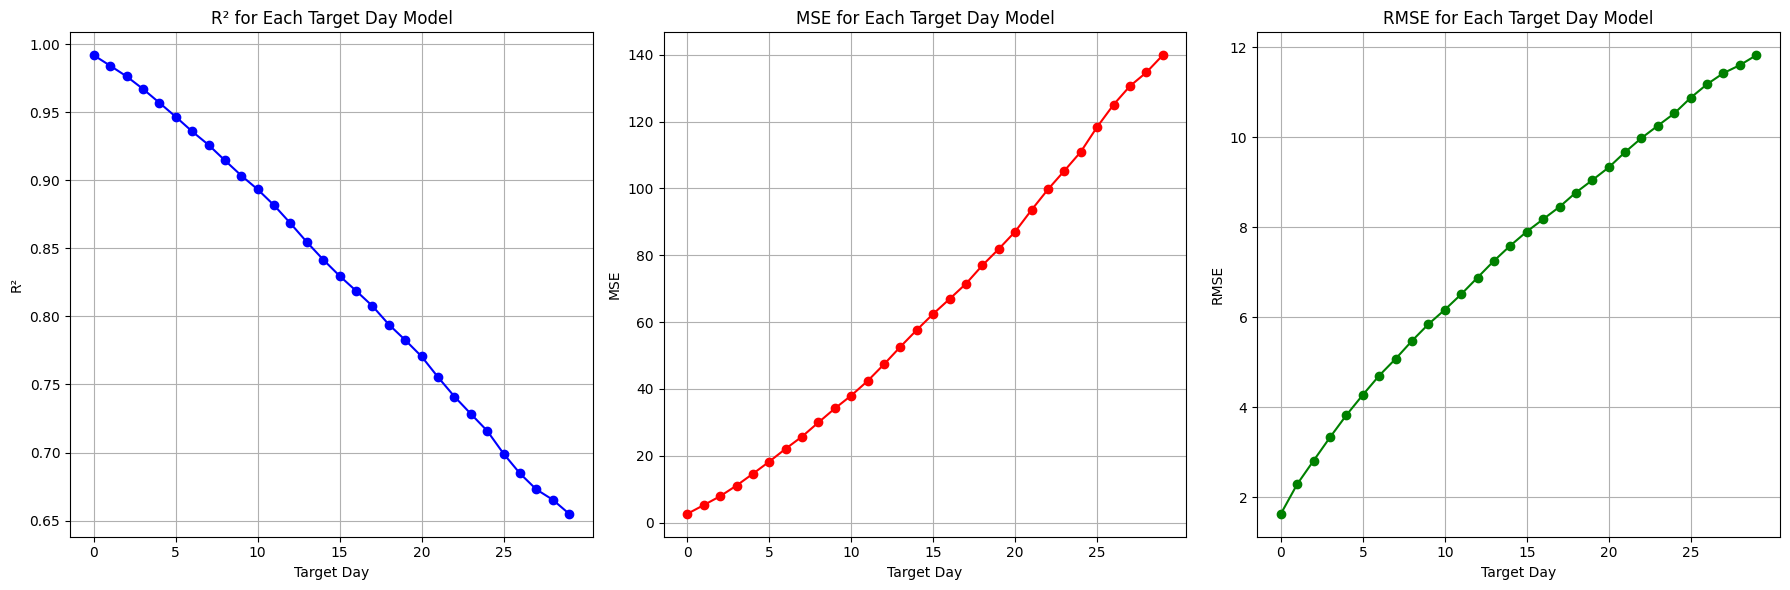

In [1178]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot R² for each target day
axes[0].plot(list(r2_scores_per_day.keys()), list(r2_scores_per_day.values()), color='blue', marker='o')
axes[0].set_title('R² for Each Target Day Model')
axes[0].set_xlabel('Target Day')
axes[0].set_ylabel('R²')
axes[0].grid()

# Plot MSE for each target day
axes[1].plot(list(mse_scores_per_day.keys()), list(mse_scores_per_day.values()), color='red', marker='o')
axes[1].set_title('MSE for Each Target Day Model')
axes[1].set_xlabel('Target Day')
axes[1].set_ylabel('MSE')
axes[1].grid()

# Plot RMSE for each target day
axes[2].plot(list(rmse_scores_per_day.keys()), list(rmse_scores_per_day.values()), color='green', marker='o')
axes[2].set_title('RMSE for Each Target Day Model')
axes[2].set_xlabel('Target Day')
axes[2].set_ylabel('RMSE')
axes[2].grid()

# Set x-axis ticks every 5 target days and label them as 0, 5, 10, ...
xticks = [i for i in range(0, len(r2_scores_per_day), 5)]  # Numbers 0, 5, 10, ...
for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)  # Set tick labels to just numbers

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()